In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models

In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv") #, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 410

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 35830 training examples and 13186 validation examples


In [4]:
model = models.FivemerModel(train_dataset)
burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)
# model.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [0/100]	 Loss: 0.073495035	 Val Loss: 0.084000654
Epoch [1/100]	 Loss: 0.062208902	 Val Loss: 0.067349113
Epoch [2/100]	 Loss: 0.059053748	 Val Loss: 0.067144179
Epoch [3/100]	 Loss: 0.058997307	 Val Loss: 0.067111739
Epoch [4/100]	 Loss: 0.05899105	 Val Loss: 0.06711745
Epoch [5/100]	 Loss: 0.058983305	 Val Loss: 0.067150699
Epoch [6/100]	 Loss: 0.058993128	 Val Loss: 0.067140964
Epoch [7/100]	 Loss: 0.059001949	 Val Loss: 0.067114267
Epoch [8/100]	 Loss: 0.058993668	 Val Loss: 0.067127306
Epoch 00008: reducing learning rate of group 0 to 2.0000e-02.
Epoch [9/100]	 Loss: 0.058917746	 Val Loss: 0.067057249
Epoch [10/100]	 Loss: 0.058887266	 Val Loss: 0.067042808
Epoch [11/100]	 Loss: 0.058886074	 Val Loss: 0.067040638
Epoch [12/100]	 Loss: 0.05888464	 Val Loss: 0.067042616
Epoch [13/100]	 Loss: 0.058886952	 Val Loss: 0.06703357
Epoch [14/100]	 Loss: 0.058886581	 Val Loss: 0.067039825
Epoch [15/100]	 Loss: 0.058886829	 Val Loss: 0.067043895
Epoch [16/100]	 Los

Training with regularization coefficient 0
Epoch [0/100]	 Loss: 0.073287866	 Val Loss: 0.083618159
Epoch [1/100]	 Loss: 0.062263629	 Val Loss: 0.067387537
Epoch [2/100]	 Loss: 0.059069216	 Val Loss: 0.067182131
Epoch [3/100]	 Loss: 0.058987923	 Val Loss: 0.067127105
Epoch [4/100]	 Loss: 0.058986592	 Val Loss: 0.067155805
Epoch [5/100]	 Loss: 0.058981411	 Val Loss: 0.067110047
Epoch [6/100]	 Loss: 0.058984362	 Val Loss: 0.067101307
Epoch [7/100]	 Loss: 0.058976247	 Val Loss: 0.06716363
Epoch [8/100]	 Loss: 0.058988737	 Val Loss: 0.067143398
Epoch [9/100]	 Loss: 0.058981597	 Val Loss: 0.067132014
Epoch [10/100]	 Loss: 0.058979984	 Val Loss: 0.067116192
Epoch [11/100]	 Loss: 0.058986373	 Val Loss: 0.067140105
Epoch 00011: reducing learning rate of group 0 to 2.0000e-02.
Epoch [12/100]	 Loss: 0.05890322	 Val Loss: 0.067059517
Epoch [13/100]	 Loss: 0.058864731	 Val Loss: 0.067050191
Epoch [14/100]	 Loss: 0.058861272	 Val Loss: 0.067049087
Epoch [15/100]	 Loss: 0.058859944	 Val Loss: 0.06704

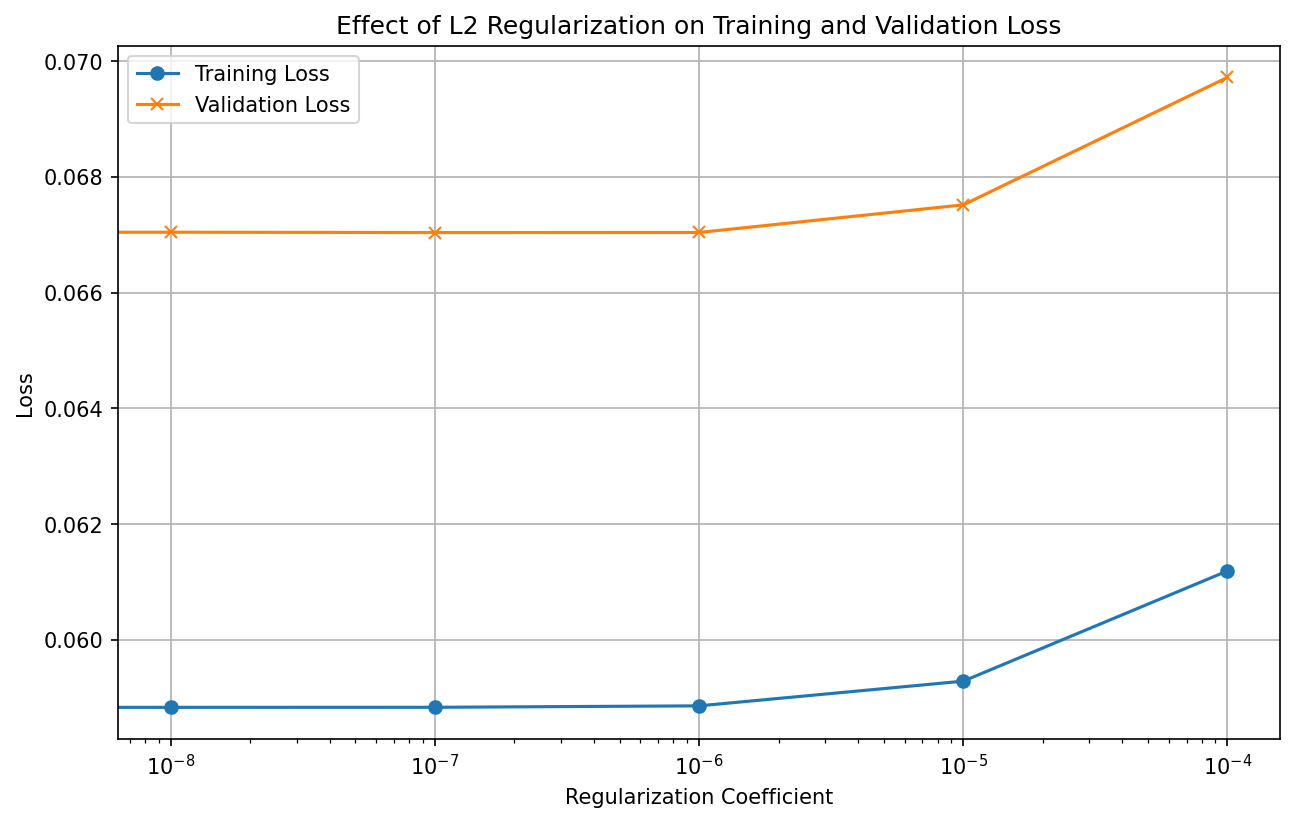

In [5]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = models.FivemerModel(train_dataset)
    burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=100)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
regularization_results_df

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.058830,0.067044
1,1.000000e-08,0.058831,0.067043
2,1.000000e-07,0.058832,0.067037
3,1.000000e-06,0.058857,0.067038
4,1.000000e-05,0.059283,0.067516
5,1.000000e-04,0.061188,0.069719
